In [702]:
from glob import glob
import json
import os

import numpy as np
import pandas as pd

from plotnine import *

from dataclasses import dataclass
from collections import defaultdict
from typing import Dict, List, Set

# TODO

- combine pipeline into a single location
- put everything in github
- run on past batch of sequencing

**Downstream analysis**
- compare to SNV data in COVIDCG and see which lineages or if novel SNVs
- merge tables with ASVs from multiple batches
- plot abundances over time and space

# Define amplicons

In [703]:
# primer locations:
s1s2_F1 = [22985, 23004]
s1s2_F2 =[23202, 23221]
s1s2_R2 = [23741, 23763]
s1s2_R1 = [23892, 23913]
ntd_F1 = [21663, 21686]
ntd_F2 = [21707, 21729]
ntd_R2 = [22221, 22241]
ntd_R1 = [22322, 22341]
rbd_F1 = [22732, 22758]
rbd_F2 = [22773,22794]
rbd_R2 = [23300, 23322]
rbd_R1 = [23382,23403]

rbd_range = [22795, 23299]
s1s2_range = [23222, 23740]
ntd_range = [21730, 22220]

amplicon_ranges = {'RBD': [22795, 23299], 'S1S2': [23222, 23740], 'NTD': [21730, 22220]}


# primer locations:
primers = {'s1s2_F1': [22985, 23004],
's1s2_F2': [23202, 23221],
's1s2_R2': [23741, 23763],
's1s2_R1': [23892, 23913],
'ntd_F1': [21663, 21686],
'ntd_F2': [21707, 21729],
'ntd_R2': [22221, 22241],
'ntd_R1': [22322, 22341],
'rbd_F1': [22732, 22758],
'rbd_F2': [22773,22794],
'rbd_R2': [23300, 23322],
'rbd_R1': [23382,23403]}

In [808]:
amplicon = 'RBD'

# Load and process the GISAID mutation table from COVID-CG

In [809]:
covid_cg_snvs1 = "/Users/rosekantor/data/wbe_scv/variant_info/consensus_mutations_covidcg_1perc_120721.json"
var1_df = pd.read_json(covid_cg_snvs1)
var1_df = var1_df.rename(columns={'pos':'position', 'name':'variant'})

In [810]:
omicron_df = var1_df[(var1_df.variant == 'B.1.1.529') & (var1_df.fraction > 0.4)]
omicron_df

,variant,count,fraction,mutation_id,position,ref,alt,mutation_name
18595,B.1.1.529,381,1.000000,69,10029,C,T,C10029T
18596,B.1.1.529,375,0.984252,1056,10449,C,A,C10449A
18597,B.1.1.529,381,1.000000,11199,14408,C,T,C14408T
18598,B.1.1.529,377,0.989501,13118,15240,C,T,C15240T
18600,B.1.1.529,368,0.965879,31146,21765,TACATG,-,TACATG21765-
18601,B.1.1.529,377,0.989501,31493,21846,C,T,C21846T
18602,B.1.1.529,331,0.868766,32838,22194,ATT,-,ATT22194-
18603,B.1.1.529,313,0.821522,32883,22205,-,GAGCCAGAA,-22205GAGCCAGAA
18604,B.1.1.529,375,0.984252,34179,22578,G,A,G22578A
18606,B.1.1.529,336,0.881890,34455,22674,C,T,C22674T


In [811]:
for k in primers.keys():
    start = primers[k][0]
    stop = primers[k][1]
    
    print(k)
    display(omicron_df[(omicron_df.position >= start) &
                       (omicron_df.position <= stop)])

s1s2_F1


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name
18610,B.1.1.529,354,0.929134,35424,22992,G,A,G22992A
18611,B.1.1.529,354,0.929134,35435,22995,C,A,C22995A


s1s2_F2


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name
18618,B.1.1.529,381,1.0,36103,23202,C,A,C23202A


s1s2_R2


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name


s1s2_R1


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name


ntd_F1


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name


ntd_F2


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name


ntd_R2


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name


ntd_R1


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name


rbd_F1


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name


rbd_F2


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name


rbd_R2


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name


rbd_R1


,variant,count,fraction,mutation_id,position,ref,alt,mutation_name
18619,B.1.1.529,381,1.0,36589,23403,A,G,A23403G


In [812]:
# filter at 90% and make sets to test
# # notes
# insertion snv_name looks like '-29799A'
# deletion snv_name looks like 'GTTATG515-'
# but there are no insertions or deletions at 90% threshold

## set to 50% frequency
var_filt_df = var1_df[(var1_df.fraction > 0.5) &
                   (var1_df.position >= amplicon_ranges[amplicon][0]) &
                   (var1_df.position <= amplicon_ranges[amplicon][1])][['variant', 'mutation_name']]
var_filt_df = var_filt_df.groupby('variant').agg(lambda x: x.tolist()).reset_index()

variant_snvs_dict = {}
for r in var_filt_df.itertuples():
    variant_snvs_dict[r.variant] = set(r.mutation_name)

# Load sample data

In [813]:
# load nextclade output
nextclade_df = pd.read_csv(f'/Users/rosekantor/data/wbe_scv/results_sgene/nextclade_out/{amplicon}_combined_nextclade.csv', sep=';')
nextclade_df = nextclade_df.replace(np.nan, '')
nextclade_df[['seqName', 'clade', 'substitutions', 'deletions', 'insertions',
       'frameShifts', 'aaSubstitutions', 'aaDeletions', 'missing', 'nonACGTNs',
       'pcrPrimerChanges', 'alignmentScore', 'alignmentStart', 'alignmentEnd']].head()

,seqName,clade,substitutions,deletions,insertions,frameShifts,aaSubstitutions,aaDeletions,missing,nonACGTNs,pcrPrimerChanges,alignmentScore,alignmentStart,alignmentEnd
0,Seq1,20B,"T22917G,C22995A",,,,"S:L452R,S:T478K",,,,,1507,22794,23299
1,Seq2,20B,"T22917G,C22995A,C23202T",,,,"S:L452R,S:T478K,S:T547I",,,,,1503,22794,23299
2,Seq3,21J (Delta),"T22917G,C22995A,T23284C",,,,"S:L452R,S:T478K",,,,,1503,22794,23299
3,Seq4,21I (Delta),"G22813T,T22917G,C22995A",,,,"S:K417N,S:L452R,S:T478K",,,,,1503,22794,23299
4,Seq5,19A,,,,,,,,,,1515,22794,23299


In [814]:
# Filter the dada2 output by abundance

abund_df = pd.read_csv(f'/Users/rosekantor/data/wbe_scv/results_sgene/{amplicon}_combined_dada2_out.csv')

# generate seqnames for columns to match the names in the fasta used by nextclade
seq_count = len(abund_df.columns)
seq_names = ['Seq'+str(x) for x in range(seq_count+1)][1:]
abund_df.columns = seq_names

# drop samples (rows) with fewer than 1000 reads total
abund_df = abund_df.drop(abund_df.index[abund_df.sum(axis=1) < 1000])

# if a seq has < 10 reads in a sample, change readcount to zero to avoid low-abundance artefacts
abund_df = abund_df.mask(abund_df < 10, 0)

# normalize to get relative abundance within samples
abund_df = abund_df.div(abund_df.sum(axis=1), axis=0)

# if a seq is < 5%, mask so we aren't considering rare variants since these will add noise
abund_df = abund_df.mask(abund_df < 0.01, 0)

# drop columns/amplicon sequences that sum to zero after all this masking
abund_df = abund_df.drop(abund_df.columns[abund_df.sum(axis=0) == 0], axis=1)

# round proportions so easier to look at and convert to percentages
abund_df = abund_df.round(3) * 100

# order the columns based on average abundance in a sample
columns_ordered = abund_df.mean(axis=0).sort_values(ascending=False).index.to_list()
abund_df = abund_df[columns_ordered]

abund_df.head()

,Seq1,Seq3,Seq4,Seq16,Seq6,Seq2,Seq5,Seq14,Seq23,Seq7,...,Seq95,Seq107,Seq69,Seq36,Seq71,Seq72,Seq37,Seq38,Seq48,Seq79
RBD_D_OSP_INF_082121_1,49.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,0.0
RBD_F_F_INF_082421_1,97.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RBD_J_J_Kerr_082421_1,97.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RBD_J_J_PC_082521_1,1.3,0.0,0.0,0.0,0.0,91.3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.6,0.0,0.0,2.4,2.3,0.0,0.0
RBD_L_L_INF_082421_1,97.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [815]:
# sample names from batch 1 RBD have prefixes: 'RBD', 'rRd', 'STD'
# STD and rRd are duplicates with different RNA prep steps, just take rRd 
# also keep all RBD (done in-house)
# remove STD

abund_df = abund_df[~abund_df.index.str.startswith('STD')]
# extract sample names without prefixes, for samples that have them (all else will be NaN)
abund_df['alt_name'] = abund_df.index.str.extract(r'.+_(.+_.+_.+_.+_.+)')[0].to_list()
abund_df['sample_name'] = abund_df.index
abund_df.loc[~abund_df.alt_name.isna(), 'sample_name'] = abund_df.alt_name
abund_df = abund_df.set_index('sample_name')
abund_df = abund_df.drop(columns='alt_name')

# merge names with abundance data

In [816]:
# load qPCR data and sample inventory
samples_df = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/full_wastewater_dataset_newformat_withResidential.csv')

# make informative sample names
sample_names = abund_df.index
names_df = samples_df[samples_df.Sample.isin(sample_names)][['Sample', 'county', 'site_full_name', 'date_sampling']]
names_df['sample_name'] = names_df[['county', 'site_full_name', 'date_sampling']].agg('_'.join, axis=1)
names_df.tail()

,Sample,county,site_full_name,date_sampling,sample_name
4942,X_2_INF_110421_1,Kern,City of Bakersfield,2021-11-04,Kern_City of Bakersfield_2021-11-04
5006,V_V_INF_110921_1,Imperial,Calexico,2021-11-09,Imperial_Calexico_2021-11-09
5008,W_W_INF_110921_1,San Bernardino,San Bernardino,2021-11-09,San Bernardino_San Bernardino_2021-11-09
5031,K_K_INF_111021_1,Contra Costa,Central San,2021-11-10,Contra Costa_Central San_2021-11-10
5033,U_U_INF_110921_1,Los Angeles,Hyperion,2021-11-09,Los Angeles_Hyperion _2021-11-09


In [817]:
# merge with abundance data
abund_named_df = names_df.merge(abund_df, how='outer', left_on='Sample', right_index=True).reset_index(drop=True)
# make sure controls and any other samples without names keep their names (since they don't have county or site names)
abund_named_df.loc[abund_named_df.sample_name.isna(), 'sample_name'] = abund_named_df['Sample']

In [818]:
abund_named_melt_df = abund_named_df.melt(id_vars=['Sample', 'county', 'site_full_name', 'date_sampling', 'sample_name'],
                                         var_name='Sequence',
                                         value_name='Abundance')

abund_named_melt_df.date_sampling = pd.to_datetime(abund_named_melt_df.date_sampling)

# order the sequences in the order they appear in the table, so they will plot nicely
#abund_named_melt_df.Sequence = pd.Categorical(abund_named_melt_df.Sequence, ordered=True, categories=abund_df.columns)
abund_named_melt_df.head()

,Sample,county,site_full_name,date_sampling,sample_name,Sequence,Abundance
0,L_L_INF_080921_2,Contra Costa,Delta Diablo,2021-08-09,Contra Costa_Delta Diablo_2021-08-09,Seq1,60.5
1,S_S_INF_080621_2,Solano,City of Vacaville,2021-08-06,Solano_City of Vacaville_2021-08-06,Seq1,91.6
2,S_S_INF_080921_2,Solano,City of Vacaville,2021-08-09,Solano_City of Vacaville_2021-08-09,Seq1,35.2
3,C_C_INF_081021_2,Alameda,EBMUD Influent,2021-08-10,Alameda_EBMUD Influent_2021-08-10,Seq1,73.4
4,D_OSP_INF_080921_2,SF,Oceanside Treatment Plant,2021-08-09,SF_Oceanside Treatment Plant_2021-08-09,Seq1,75.6


In [819]:
bakersfield_seqs = abund_named_melt_df[(abund_named_melt_df.site_full_name=='City of Bakersfield')].Sequence.unique()
bakersfield_seqs

array(['Seq1', 'Seq3', 'Seq4', 'Seq16', 'Seq6', 'Seq2', 'Seq5', 'Seq14',
       'Seq23', 'Seq7', 'Seq9', 'Seq17', 'Seq42', 'Seq39', 'Seq11',
       'Seq8', 'Seq10', 'Seq20', 'Seq13', 'Seq12', 'Seq15', 'Seq24',
       'Seq35', 'Seq50', 'Seq74', 'Seq28', 'Seq52', 'Seq18', 'Seq29',
       'Seq49', 'Seq22', 'Seq19', 'Seq51', 'Seq30', 'Seq31', 'Seq26',
       'Seq27', 'Seq53', 'Seq25', 'Seq47', 'Seq33', 'Seq40', 'Seq41',
       'Seq34', 'Seq70', 'Seq32', 'Seq21', 'Seq44', 'Seq43', 'Seq99',
       'Seq45', 'Seq90', 'Seq46', 'Seq95', 'Seq107', 'Seq69', 'Seq36',
       'Seq71', 'Seq72', 'Seq37', 'Seq38', 'Seq48', 'Seq79'], dtype=object)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


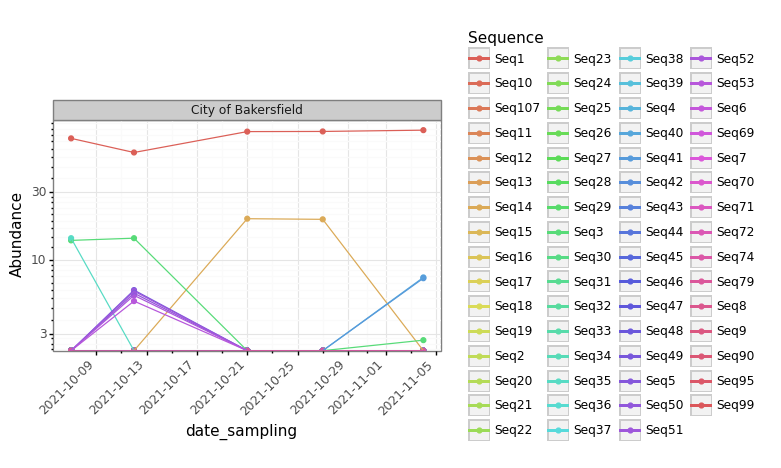

<ggplot: (389561986)>

In [820]:
(ggplot(abund_named_melt_df[(abund_named_melt_df.site_full_name=='City of Bakersfield') &
                            (abund_named_melt_df.Sequence.isin(bakersfield_seqs))], 
        aes(y='Abundance', x='date_sampling', color='Sequence'))+
geom_point()+
geom_line()+
 scale_y_log10()+
facet_wrap('~site_full_name', ncol=3)+
theme_bw()+
theme(figure_size=(5,3), axis_text_x=element_text(angle=45, hjust=1)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


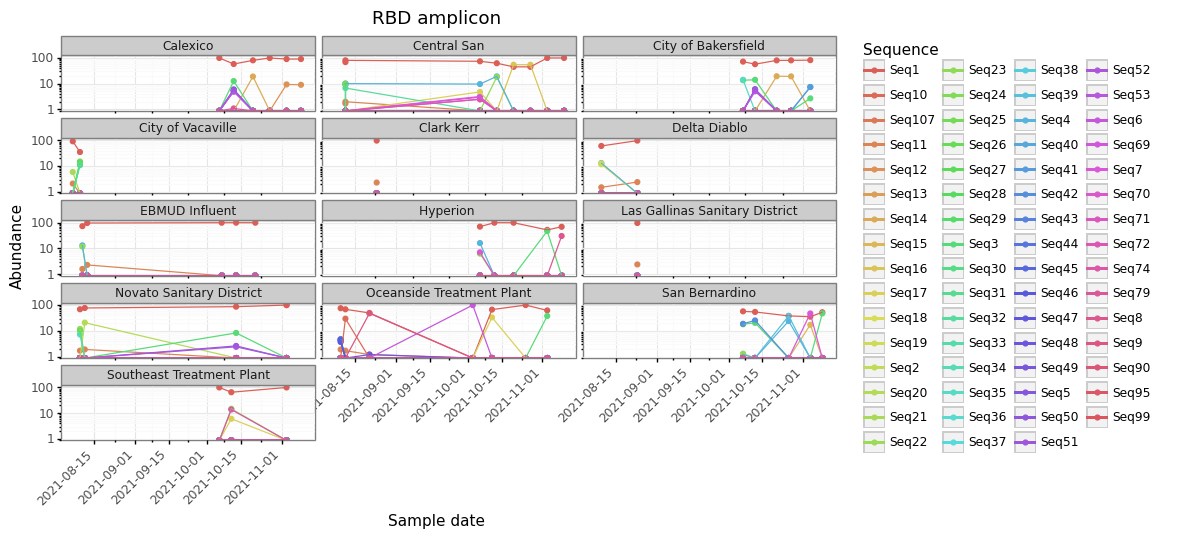

<ggplot: (681848495)>

In [821]:
(ggplot(abund_named_melt_df[~(abund_named_melt_df.site_full_name.isna()) &
                            ~(abund_named_melt_df.site_full_name.isin(['Piedmont and Channing', 'City of American Canyon']))
                                                                      # , 'Las Gallinas Sanitary District'
                            #&
                           # (abund_named_melt_df.Sequence.isin(['Seq1', 'Seq2', 'Seq4','Seq5', 'Seq6','Seq7', 'Seq8','Seq9']))
                           ], 
        aes(y='Abundance', x='date_sampling', color='Sequence'))+
geom_point()+
geom_line()+
facet_wrap('~site_full_name', ncol=3)+
ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
scale_y_log10()+
theme_bw()+
theme(figure_size=(10,5), axis_text_x=element_text(angle=45, hjust=1)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


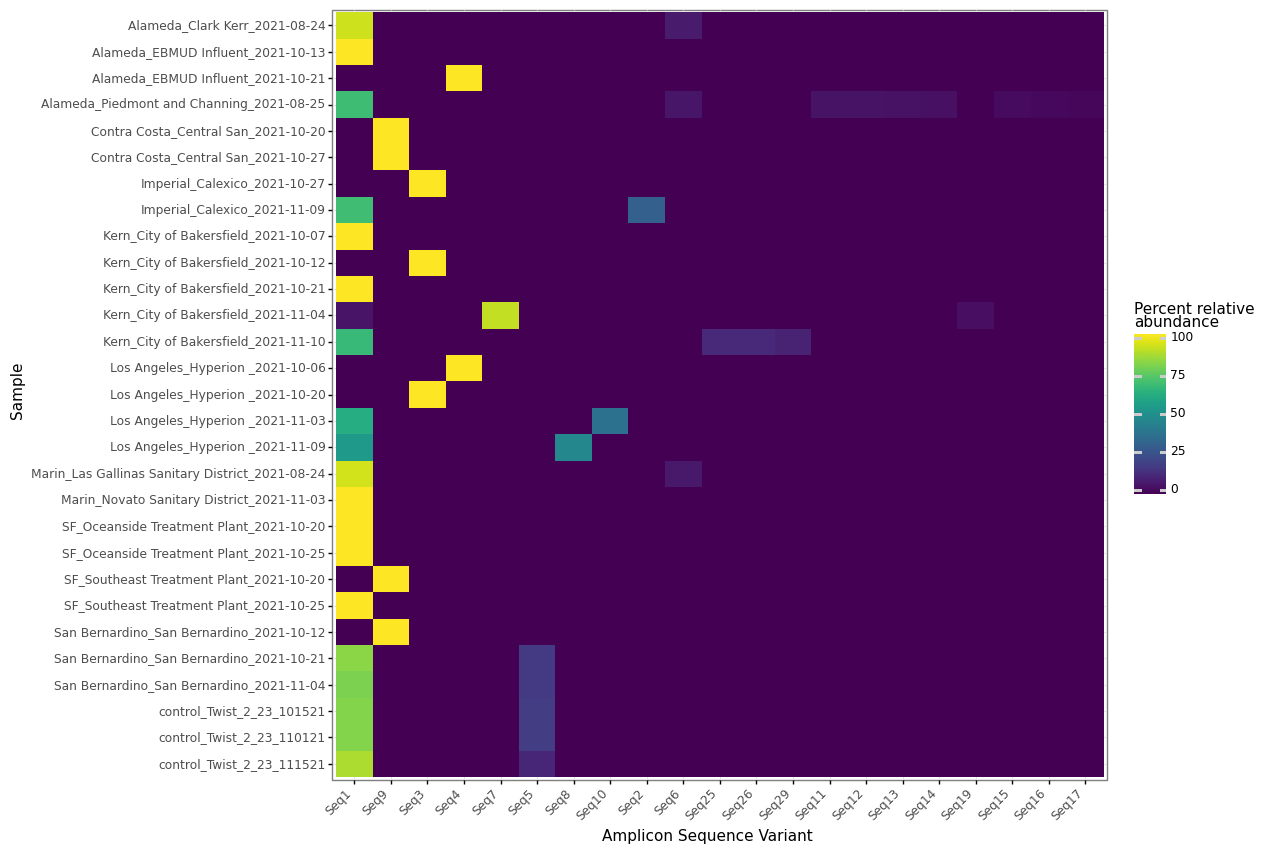

<ggplot: (388215812)>

In [802]:
abund_named_melt_df.Sequence = pd.Categorical(abund_named_melt_df.Sequence, ordered=True, categories=abund_df.columns)
(ggplot(abund_named_melt_df, aes(y='sample_name', x='Sequence', fill='Abundance'))+
geom_tile()+
#facet_wrap('~site_full_name', ncol=1)+
coord_trans(y='reverse')+ # reverse the y axis
labs(fill='Percent relative\nabundance\n')+
xlab('Amplicon Sequence Variant')+
ylab('Sample')+
theme_bw()+
theme(figure_size=(10,10), axis_text_x=element_text(angle=45, hjust=1)))

In [770]:
novato = abund_named_df[abund_named_df.county == 'Marin']

novato = novato.drop(novato.columns[novato.sum(axis=0) == 0], axis=1)

novato

,Sample,county,site_full_name,date_sampling,sample_name,Seq1,Seq2,Seq6,Seq12,Seq13,Seq16
7,I_I_INF_100721_2,Marin,Novato Sanitary District,2021-10-07,Marin_Novato Sanitary District_2021-10-07,45.9,27.4,5.5,7.7,6.6,5.9
15,I_I_INF_101321_1,Marin,Novato Sanitary District,2021-10-13,Marin_Novato Sanitary District_2021-10-13,0.0,100.0,0.0,0.0,0.0,0.0
30,I_I_INF_110321_1,Marin,Novato Sanitary District,2021-11-03,Marin_Novato Sanitary District_2021-11-03,0.0,99.8,0.0,0.0,0.0,0.0
31,I_I_INF_110321_2,Marin,Novato Sanitary District,2021-11-03,Marin_Novato Sanitary District_2021-11-03,76.2,23.6,0.0,0.0,0.0,0.0


## Merge abundance with NextStrain info

In [822]:
nextclade_short_df = nextclade_df[['seqName', 'clade', 'substitutions', 'deletions', 'insertions', 'frameShifts', 'aaSubstitutions', 'aaDeletions']]
nextclade_short_df = nextclade_short_df[nextclade_short_df.seqName.isin(abund_df.columns)]

nextclade_short_df.head(10)

,seqName,clade,substitutions,deletions,insertions,frameShifts,aaSubstitutions,aaDeletions
0,Seq1,20B,"T22917G,C22995A",,,,"S:L452R,S:T478K",
1,Seq2,20B,"T22917G,C22995A,C23202T",,,,"S:L452R,S:T478K,S:T547I",
2,Seq3,21J (Delta),"T22917G,C22995A,T23284C",,,,"S:L452R,S:T478K",
3,Seq4,21I (Delta),"G22813T,T22917G,C22995A",,,,"S:K417N,S:L452R,S:T478K",
4,Seq5,19A,,,,,,
5,Seq6,20B,"T22917G,C22995A,A23085T",,,,"S:L452R,S:T478K,S:Y508F",
6,Seq7,20B,"T22917G,G22984T,C22995A",,,,"S:L452R,S:Q474H,S:T478K",
7,Seq8,20B,"G22817T,T22917G,C22995A",,,,"S:A419S,S:L452R,S:T478K",
8,Seq9,20B,"T22917G,C22995A,G23224A",,,,"S:L452R,S:T478K",
9,Seq10,20B,"G22820T,T22917G,C22995A",,,,"S:D420Y,S:L452R,S:T478K",


In [826]:
seq41_subs = nextclade_short_df[nextclade_short_df.seqName.isin(['Seq41'])].substitutions.to_list()

In [827]:
var1_df[var1_df.mutation_name.isin(seq41_subs)]

,variant,count,fraction,mutation_id,position,ref,alt,mutation_name


In [825]:
kern = abund_named_df[abund_named_df.county == 'Kern']
kern = kern.drop(kern.columns[kern.sum(axis=0) == 0], axis=1)
kern

,Sample,county,site_full_name,date_sampling,sample_name,Seq1,Seq3,Seq14,Seq35,Seq50,Seq52,Seq49,Seq51,Seq53,Seq40,Seq41
25,X_2_INF_100721_1,Kern,City of Bakersfield,2021-10-07,Kern_City of Bakersfield_2021-10-07,72.1,13.7,0.0,14.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,X_2_INF_101221_1,Kern,City of Bakersfield,2021-10-12,Kern_City of Bakersfield_2021-10-12,57.3,14.2,0.0,0.0,5.8,5.6,6.1,6.0,5.1,0.0,0.0
39,X_2_INF_102121_1,Kern,City of Bakersfield,2021-10-21,Kern_City of Bakersfield_2021-10-21,80.5,0.0,19.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,X_2_INF_102721_1,Kern,City of Bakersfield,2021-10-27,Kern_City of Bakersfield_2021-10-27,80.7,0.0,19.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,X_2_INF_110421_1,Kern,City of Bakersfield,2021-11-04,Kern_City of Bakersfield_2021-11-04,82.4,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,7.4


In [804]:
kern = abund_named_df[abund_named_df.county == 'Kern']
kern = kern.drop(kern.columns[kern.sum(axis=0) == 0], axis=1)
kern

,Sample,county,site_full_name,date_sampling,sample_name,Seq1,Seq3,Seq7,Seq25,Seq26,Seq29,Seq19
4,X_2_INF_100721_1,Kern,City of Bakersfield,2021-10-07,Kern_City of Bakersfield_2021-10-07,100.0,0.0,0.0,0.0,0.0,0.0,0.0
6,X_2_INF_101221_1,Kern,City of Bakersfield,2021-10-12,Kern_City of Bakersfield_2021-10-12,0.0,100.0,0.0,0.0,0.0,0.0,0.0
14,X_2_INF_102121_1,Kern,City of Bakersfield,2021-10-21,Kern_City of Bakersfield_2021-10-21,100.0,0.0,0.0,0.0,0.0,0.0,0.0
22,X_2_INF_110421_1,Kern,City of Bakersfield,2021-11-04,Kern_City of Bakersfield_2021-11-04,5.3,0.0,91.0,0.0,0.0,0.0,3.6
25,X_2_INF_111021_1,Kern,City of Bakersfield,2021-11-10,Kern_City of Bakersfield_2021-11-10,67.2,0.0,0.0,11.7,11.7,9.4,0.0


In [806]:
# s1s2
nextclade_short_df[nextclade_short_df.seqName.isin(['Seq1', 'Seq7', 'Seq25', 'Seq26', 'Seq29'])] # C23277T,A23403G,C23604G

,seqName,clade,substitutions,deletions,insertions,frameShifts,aaSubstitutions,aaDeletions
0,Seq1,20B,"A23403G,C23604G",,,,"S:D614G,S:P681R",
6,Seq7,21J (Delta),"T23284C,A23403G,G23478T,C23604G",,,,"S:D614G,S:G639V,S:P681R",
24,Seq25,21B (Kappa),"C23277T,A23403G,C23604G",23315,,,,
25,Seq26,20B,"A23403G,A23532T,C23604G",,,,"S:D614G,S:N657I,S:P681R",
28,Seq29,19A,,,23396:T,,,


In [775]:
# NTD
nextclade_short_df[nextclade_short_df.seqName.isin(['Seq36', 'Seq31', 'Seq67'])].aaSubstitutions.to_list()

['S:G142D,S:R158G,S:L179F',
 'S:G142D,S:F157I,S:R158G',
 'S:G142D,S:M153I,S:R158G,S:L179F']

In [786]:
nextclade_short_df[nextclade_short_df.seqName.isin(['Seq1','Seq9', 'Seq36', 'Seq31', 'Seq67'])]

,seqName,clade,substitutions,deletions,insertions,frameShifts,aaSubstitutions,aaDeletions
0,Seq1,21A (Delta),G21987A,22029-22034,,,"S:G142D,S:R158G","S:E156-,S:F157-"
8,Seq9,21A (Delta),"C21750T,G21987A","22029-22034,22121",,S:187-1274,"S:T63I,S:G142D,S:R158G","S:E156-,S:F157-"
30,Seq31,20B,"G21987A,C22097T",22029-22034,,,"S:G142D,S:R158G,S:L179F","S:E156-,S:F157-"
35,Seq36,21A (Delta),"G21987A,G22026T",22029-22034,,,"S:G142D,S:F157I,S:R158G","S:E154-,S:S155-"
66,Seq67,20A,"G21987A,G22021T,C22097T",22029-22034,,,"S:G142D,S:M153I,S:R158G,S:L179F","S:E156-,S:F157-"


In [784]:
var1_df[var1_df.mutation_name=='C22097T']
# seq 31 and 67 are non-delta

,variant,count,fraction,mutation_id,position,ref,alt,mutation_name
18146,B.1.1.515,14,0.233333,32534,22097,C,T,C22097T
23316,B.1.187,1,0.033333,32534,22097,C,T,C22097T


In [807]:
var1_df[var1_df.mutation_name=='C23277T']

,variant,count,fraction,mutation_id,position,ref,alt,mutation_name
40264,AY.104,218,1.000000,36293,23277,C,T,C23277T
40805,AY.32,1432,0.936560,36293,23277,C,T,C23277T
41643,AY.95,976,0.726731,36293,23277,C,T,C23277T
45834,B.1.1.407,1,0.055556,36293,23277,C,T,C23277T
46860,B.1.1.486,515,0.979087,36293,23277,C,T,C23277T
49691,B.1.177.88,71,1.000000,36293,23277,C,T,C23277T
50236,B.1.208,3,0.130435,36293,23277,C,T,C23277T
51651,B.1.284,29,0.329545,36293,23277,C,T,C23277T
53109,B.1.397,24,0.154839,36293,23277,C,T,C23277T
53123,B.1.398,16,0.056338,36293,23277,C,T,C23277T


# make plots for delta/nondelta based on the L452R and T478K mutations - only for RBD amplicon

In [727]:
delta_seqs = nextclade_short_df[(nextclade_short_df.substitutions.str.contains('T22917G')) &
                   (nextclade_short_df.substitutions.str.contains('C22995A'))].seqName.to_list()

In [729]:
abund_named_df['delta'] = abund_named_df[delta_seqs].sum(axis=1)
abund_named_delta_df = abund_named_df.drop(columns=delta_seqs)
abund_named_delta_df = abund_named_delta_df.drop(columns='Seq5')

abund_named_melt_delta_df = abund_named_delta_df.melt(id_vars=['Sample', 'county', 'site_full_name', 'date_sampling', 'sample_name'],
                                         var_name='Sequence',
                                         value_name='Abundance')

abund_named_melt_delta_df.date_sampling = pd.to_datetime(abund_named_melt_delta_df.date_sampling)

# order the sequences in the order they appear in the table, so they will plot nicely
#abund_named_melt_df.Sequence = pd.Categorical(abund_named_melt_df.Sequence, ordered=True, categories=abund_df.columns)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


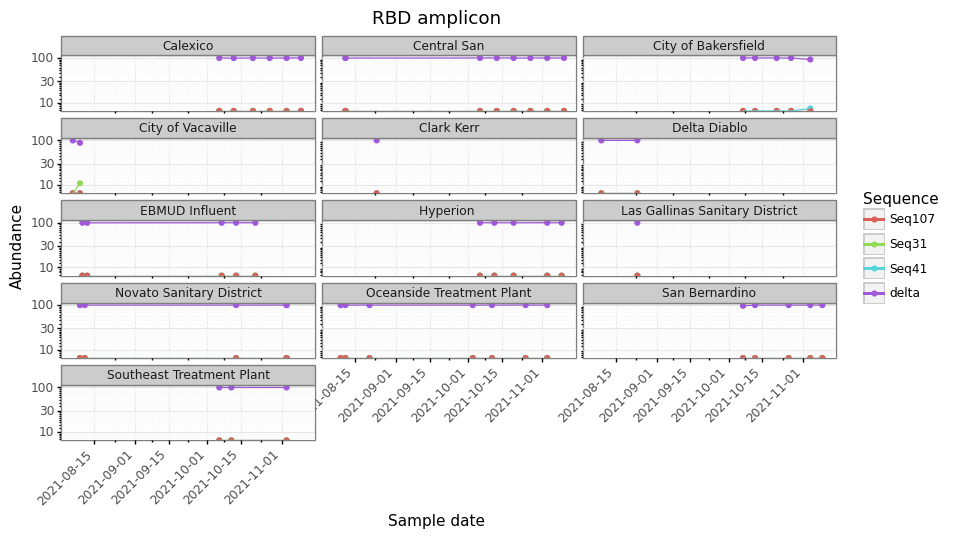

<ggplot: (378207359)>

In [730]:
(ggplot(abund_named_melt_delta_df[~(abund_named_melt_delta_df.site_full_name.isna()) &
                            ~(abund_named_melt_delta_df.site_full_name.isin(['Piedmont and Channing', 'City of American Canyon']))
                                                                      # , 'Las Gallinas Sanitary District'
                            #&
                           # (abund_named_melt_df.Sequence.isin(['Seq1', 'Seq2', 'Seq4','Seq5', 'Seq6','Seq7', 'Seq8','Seq9']))
                           ], 
        aes(y='Abundance', x='date_sampling', color='Sequence'))+
geom_point()+
geom_line()+
facet_wrap('~site_full_name', ncol=3)+
ggtitle(f'{amplicon} amplicon')+
xlab('Sample date')+
scale_y_log10()+
theme_bw()+
theme(figure_size=(10,5), axis_text_x=element_text(angle=45, hjust=1)))

# Make mutation frequency plots

In [747]:
mutations_df = []
for r in nextclade_short_df.itertuples():
    snvs = r.substitutions.split(',')
    for snv in snvs:
        mutations_df.append([r.seqName, snv])
mutations_df = pd.DataFrame.from_records(mutations_df, columns=['Sequence', 'mutation'])

mutation_freq_df = abund_named_melt_df.merge(mutations_df, on='Sequence')

In [748]:
mutation_freq_df = mutation_freq_df.groupby(['Sample', 'county', 'site_full_name',
                          'date_sampling', 'sample_name', 'mutation']).agg('sum').reset_index()

In [749]:
mutation_summary_df = mutation_freq_df.groupby('mutation').agg('max').reset_index()[['mutation', 'Abundance']]
mutation_summary_df = mutation_summary_df.sort_values('Abundance', ascending=False)
mutation_list = mutation_summary_df[mutation_summary_df.Abundance > 5]['mutation'].to_list()

In [750]:
mutation_freq_df = mutation_freq_df[mutation_freq_df.mutation.isin(mutation_list)].copy()
mutation_freq_df.mutation = pd.Categorical(mutation_freq_df.mutation, ordered=True, categories=mutation_list)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


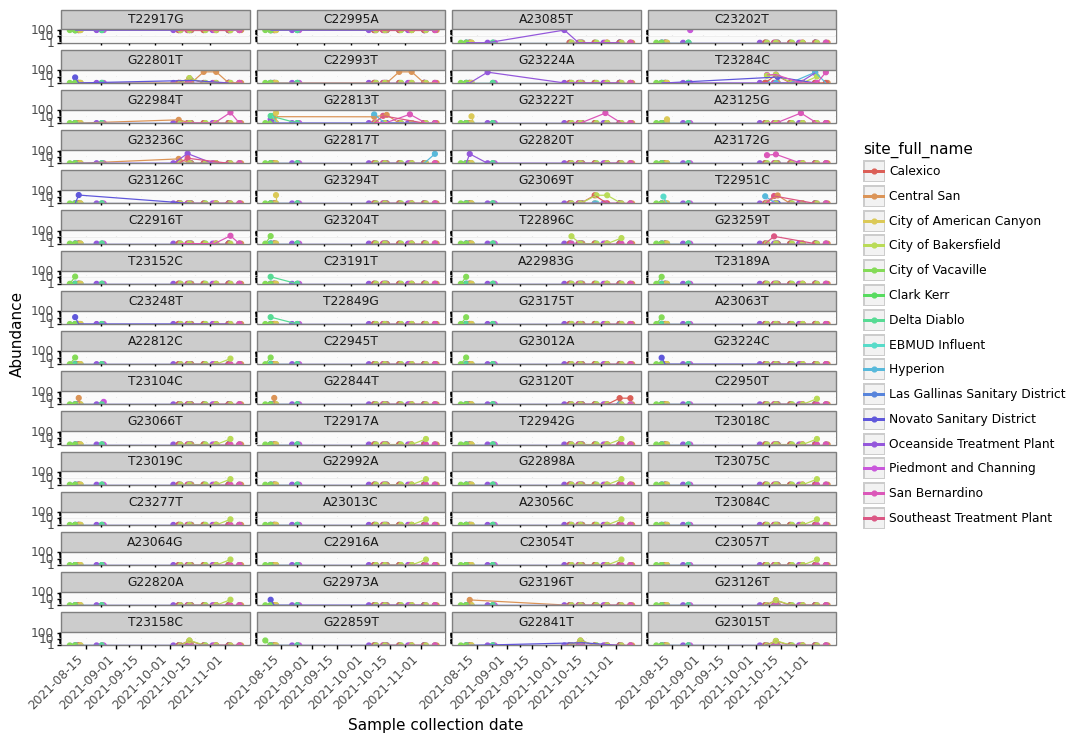

<ggplot: (389427800)>

In [751]:
(ggplot(mutation_freq_df, aes(x='date_sampling', y='Abundance', color='site_full_name'))+
geom_point()+
geom_line()+
 xlab('Sample collection date')+
 scale_y_log10()+
facet_wrap('~mutation', ncol=4)+
theme_bw()+
theme(figure_size=(10,8), axis_text_x=element_text(angle=45, hjust=1)))

In [684]:
var1_df[var1_df.mutation_name == 'G22813T']

,variant,count,fraction,mutation_id,position,ref,alt,mutation_name
40518,AY.1,2215,1.000000,34650,22813,G,T,G22813T
40950,AY.2,2456,1.000000,34650,22813,G,T,G22813T
42299,B.1.1.119,1,0.040000,34650,22813,G,T,G22813T
46384,B.1.1.422,1,0.055556,34650,22813,G,T,G22813T
47698,B.1.1.529,100,0.462963,34650,22813,G,T,G22813T
47727,B.1.1.529 (probable),7,1.000000,34650,22813,G,T,G22813T
49185,B.1.170,36,0.161435,34650,22813,G,T,G22813T
52451,B.1.351,24932,0.934973,34650,22813,G,T,G22813T
52477,B.1.351.1,6,1.000000,34650,22813,G,T,G22813T
52498,B.1.351.2,3336,0.993448,34650,22813,G,T,G22813T


In [682]:
var1_df[var1_df.mutation_name == 'T23284C']

,variant,count,fraction,mutation_id,position,ref,alt,mutation_name
2221,AY.106,132,0.055649,36076,23284,T,C,T23284C
2735,AY.116,157,0.049984,36076,23284,T,C,T23284C
4369,AY.3,43480,0.588203,36076,23284,T,C,T23284C
4414,AY.3.1,7891,0.996213,36076,23284,T,C,T23284C
8927,AY.93,206,0.057366,36076,23284,T,C,T23284C
26546,B.1.335,7,0.054688,36076,23284,T,C,T23284C
35309,B.50,2,0.181818,36076,23284,T,C,T23284C


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  warn("geom_path: Each group consist of only one "


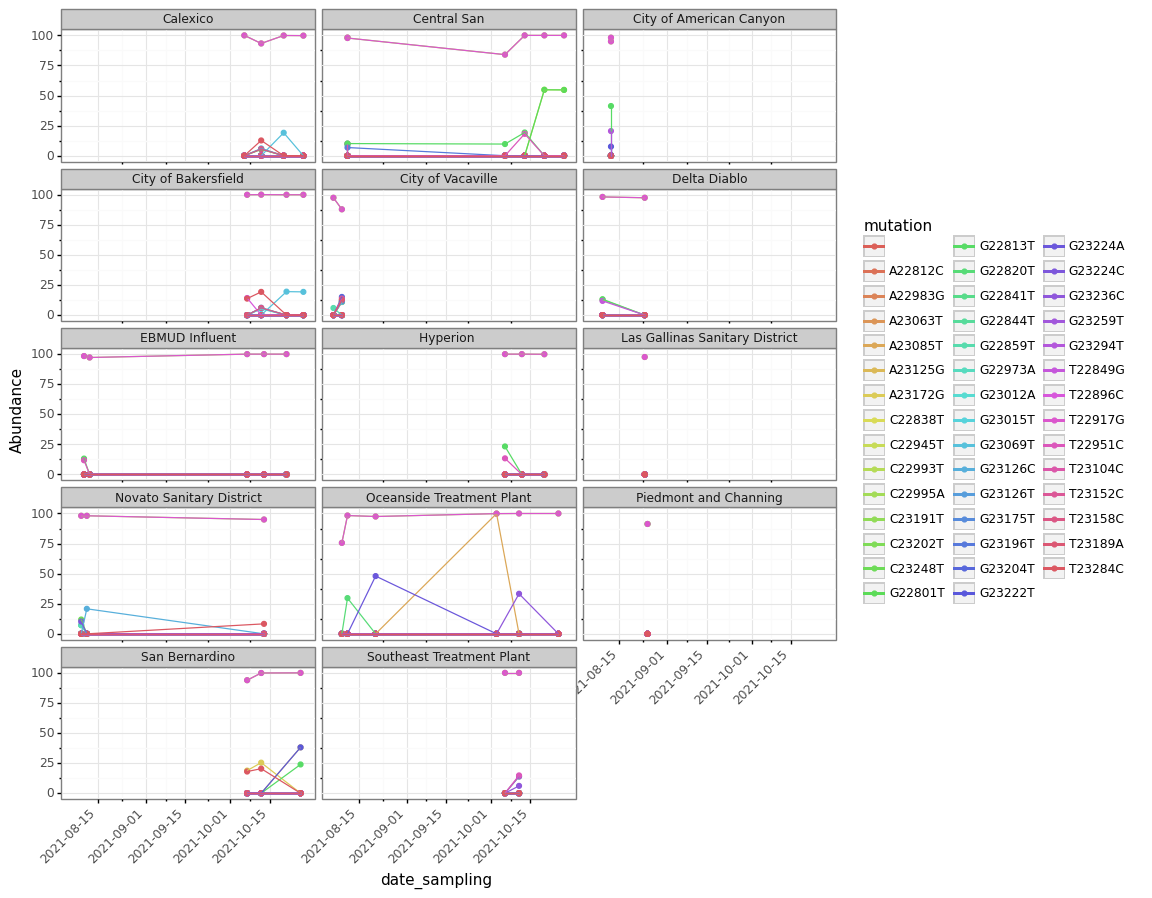

<ggplot: (682815260)>

In [588]:
(ggplot(mutation_freq_df, aes(x='date_sampling', y='Abundance', color='mutation'))+
geom_point()+
geom_line()+
facet_wrap('~site_full_name', ncol=3)+
theme_bw()+
theme(figure_size=(10,10), axis_text_x=element_text(angle=45, hjust=1)))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


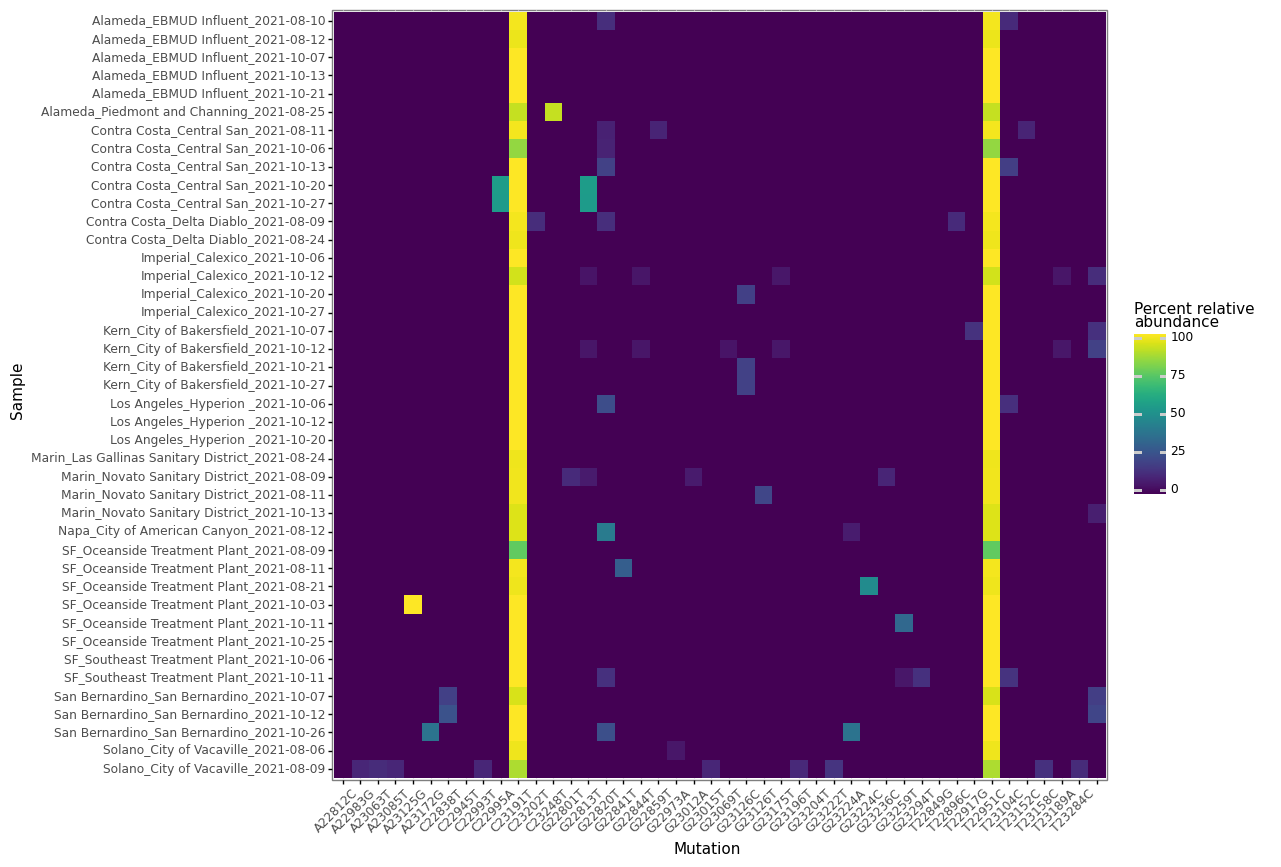

<ggplot: (377399863)>

In [586]:
(ggplot(mutation_freq_df, aes(y='sample_name', x='mutation', fill='Abundance'))+
geom_tile()+
#facet_wrap('~site_full_name', ncol=1)+
coord_trans(y='reverse')+ # reverse the y axis
labs(fill='Percent relative\nabundance\n')+
xlab('Mutation')+
ylab('Sample')+
theme_bw()+
theme(figure_size=(10,10), axis_text_x=element_text(angle=45, hjust=1)))

In [481]:
# which ones have K417N
nextclade_short_df[nextclade_short_df.aaSubstitutions.str.contains('K417N')]

,seqName,clade,substitutions,deletions,insertions,frameShifts,aaSubstitutions,aaDeletions
2,Seq3,21I (Delta),"G22813T,T22917G,C22995A",,,,"S:K417N,S:L452R,S:T478K",
40,Seq41,21I (Delta),"G22813T,C22838T,T22917G,C22995A",,,,"S:K417N,S:P426S,S:L452R,S:T478K",
60,Seq61,21I (Delta),"G22813T,T22917G,T22951C,C22995A",,,,"S:K417N,S:L452R,S:T478K",
64,Seq65,21I (Delta),"G22813T,T22917G,C22995A,G23259T",,,,"S:K417N,S:L452R,S:T478K,S:G566V",


In [419]:
nextclade_short_df[nextclade_short_df.aaSubstitutions.str.contains('N501Y')]

,seqName,clade,substitutions,deletions,insertions,frameShifts,aaSubstitutions,aaDeletions
26,Seq27,"20J (Gamma, V3)","A22812C,C22945T,G23012A,A23063T",,,,"S:K417T,S:E484K,S:N501Y",
54,Seq55,"20J (Gamma, V3)","A22812C,T22889C,C22945T,G23012A,A23063T",,,,"S:K417T,S:S443P,S:E484K,S:N501Y",
85,Seq86,19B,"A23063T,C23271A",,,,"S:N501Y,S:A570D",


In [420]:
nextclade_short_df[nextclade_short_df.aaSubstitutions.str.contains('E484A')]

,seqName,clade,substitutions,deletions,insertions,frameShifts,aaSubstitutions,aaDeletions


# assign lineages based on complete intersection of mutations

In [391]:
lineage_results = {}
for r in nextclade_short_df.itertuples():
    lineages = []
    snvs = set(r.substitutions.split(','))

    for variant in variant_snvs_dict:
        variant_snvs = variant_snvs_dict[variant]
        
        if snvs.issubset(variant_snvs):
            lineages.append(variant)
        lineage_results[r.seqName] = lineages

In [392]:
# lineage_results = {}
# for r in nextclade_short_df.itertuples():
#     lineages = []
#     snvs = set(r.substitutions.split(','))

#     for variant in variant_snvs_dict:
#         variant_snvs = variant_snvs_dict[variant]
        
#         if snvs == variant_snvs:
#             lineages.append(variant)
#         lineage_results[r.seqName] = lineages

In [393]:
lineage_results

{'Seq1': ['AY.1',
  'AY.10',
  'AY.100',
  'AY.101',
  'AY.102',
  'AY.103',
  'AY.104',
  'AY.105',
  'AY.106',
  'AY.107',
  'AY.108',
  'AY.109',
  'AY.11',
  'AY.110',
  'AY.111',
  'AY.112',
  'AY.113',
  'AY.114',
  'AY.115',
  'AY.116',
  'AY.116.1',
  'AY.117',
  'AY.118',
  'AY.119',
  'AY.120',
  'AY.120.1',
  'AY.120.2',
  'AY.120.2.1',
  'AY.121',
  'AY.122',
  'AY.122.1',
  'AY.13',
  'AY.14',
  'AY.15',
  'AY.16',
  'AY.16.1',
  'AY.17',
  'AY.18',
  'AY.19',
  'AY.2',
  'AY.20',
  'AY.20.1',
  'AY.21',
  'AY.22',
  'AY.23',
  'AY.23.1',
  'AY.24',
  'AY.25',
  'AY.26',
  'AY.27',
  'AY.28',
  'AY.29',
  'AY.29.1',
  'AY.3',
  'AY.3.1',
  'AY.30',
  'AY.31',
  'AY.32',
  'AY.33',
  'AY.34',
  'AY.34.1',
  'AY.35',
  'AY.36',
  'AY.37',
  'AY.38',
  'AY.39',
  'AY.39.1',
  'AY.39.1.1',
  'AY.39.2',
  'AY.4',
  'AY.4.1',
  'AY.4.2',
  'AY.4.2.1',
  'AY.4.3',
  'AY.4.4',
  'AY.4.5',
  'AY.40',
  'AY.41',
  'AY.42',
  'AY.43',
  'AY.43.1',
  'AY.43.2',
  'AY.44',
  'AY.45',
 